# DSGA 1007 | Programming for Data Science
# Modeling and Predicting Market Volatility: A Hybrid GARCH–XGBoost Approach
### Group: uccu
### Team members: Kathy (Ching-Chi) Chang, Yu-Lung Chen
### Github link: https://github.com/o0o0o04680/Programming_for_Data_Science

!pip install fredapi yfinance pandas numpy seaborn matplotlib scipy statsmodels arch xgboost scikit-learn

# 1. Data Processing  

In [1]:
from fredapi import Fred
import yfinance as yf
import pandas as pd
import numpy as np 

In [2]:
fred = Fred(api_key = "ed1b2123fc23b6e2a2d8db120bb68b7b")

## *Variable Description:*
### **Initial Jobless Claims (ICSA) — Weekly** 

Measures the number of people filing for unemployment benefits for the first time.

A fast, real-time indicator of labor market stress.

Rising claims → worsening economic conditions → higher market uncertainty → VIX tends to increase.

Useful for capturing macroeconomic fear that drives volatility.

### **CPI (CPIAUCSL) — Monthly Inflation**

Tracks consumer price inflation in the U.S.

High or accelerating inflation increases uncertainty about interest rate policy.

Inflation shocks often lead to sharp stock market movements and higher VIX.

Provides information about macroeconomic pressure on volatility.

### **Term Spread (T10Y3M) — Daily** 

10-year Treasury yield minus 3-month Treasury yield.

A classic recession indicator (yield curve inversion).

When the term spread turns negative, recession risk rises → investors demand protection → VIX increases.

Captures expectations about economic cycles and downturn risk.

### **DGS10 (10-Year Treasury Rate) — Daily** 

10-Year Treasury constant maturity rate.

Higher rates → higher discount rates → more volatile equity markets.

Reflects changes in monetary policy expectations.

Helps model how interest-rate uncertainty translates into market volatility.

### **Credit Spread (BAA10YM) — Monthly** 

Corporate bond yield minus 10-year Treasury yield.

Measures corporate credit risk and financial stress.

Widening credit spreads indicate rising default concerns → market fear → VIX tends to spike.

Useful for detecting systemic risk in the corporate sector.

### **S&P 500 Index (^GSPC) — Daily**

Broad measure of U.S. stock market performance.

VIX is derived from S&P 500 options → they are directly linked.

S&P500 declines generally correspond to rapid VIX increases (strong negative correlation).

Essential for reflecting current market conditions.

### **SGIXSENT — Sentiment Index (Daily)**

A text-based investor sentiment indicator.

Captures fear, optimism, and behavioral reactions not visible in macro data alone.

Negative (bearish) sentiment predicts higher volatility and VIX jumps.

Helps model the psychological component of market dynamics.

### **VIX — Daily**

The “fear index,” representing expected 30-day market volatility.

Used as the foundation for calculating log-returns.

Provides the volatility information needed for ARMA–EGARCH modeling.

### **VIX_return — Daily (log-return)**

Standard measure for volatility modeling and forecasting.

Stationary (or closer to stationary) compared to raw VIX levels.

Serves as the target variable for ARMA–EGARCH and hybrid models.

## 1.1  Data Collection and Cleaning 

In [38]:
## Retrieve key U.S. macroeconomic and financial indicators from FRED. Dates = 2018-01-01 to 2025-10-30
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
series_ids = {
    "initial_claims": "ICSA",
    "cpi": "CPIAUCSL",
    "term_spread": "T10Y3M",
    "dgs10": "DGS10",
    "credit_spread": "BAA10YM",
} 
data = {}
for name, sid in series_ids.items():
    s = fred.get_series(sid)
    s.name = name 
    data[name] = fred.get_series(sid)
    
df = pd.DataFrame(data)
df = df[(df.index >= "2018-01-01") & (df.index <= "2025-10-30")]
full_index = pd.date_range(start="2018-01-01", end="2025-10-30", freq="D")
df = df.reindex(full_index)

sp500 = yf.download("^GSPC", start="2018-01-01", end="2025-10-30", progress=False)
sp500 = sp500["Close"]
sp500.name = "sp500"

df_sent = pd.read_excel("SGIXSENT_INDEX_20040115-20252030_uccu.xlsx",
                   sheet_name=["20140115_20240115", "20240115_20251030"])
df1 = df_sent["20140115_20240115"]
df2 = df_sent["20240115_20251030"]
def clean_sentiment(df):
    df = df.iloc[1:, 1:3].copy()
    df.columns = ["SGIXSENT", "Date"]
    df["Date"] = pd.to_datetime(df["Date"])
    df["SGIXSENT"] = pd.to_numeric(df["SGIXSENT"], errors="coerce")
    df.set_index("Date", inplace=True)
    return df

df_sent1 = clean_sentiment(df_sent["20140115_20240115"])
df_sent2 = clean_sentiment(df_sent["20240115_20251030"])
df_sent = pd.concat([df_sent1, df_sent2]).sort_index()

df_sent = df_sent.loc["2018-01-01" : "2025-10-30"]
print(df_sent.head())
print(df_sent.tail())

vix = fred.get_series(
    "VIXCLS",
    observation_start="2018-01-01",
    observation_end="2025-10-30"
)
df_vix = pd.DataFrame(vix, columns=["VIX"])
df_vix.index = pd.to_datetime(df_vix.index)

dif_vix = df_vix.sort_index()
print(df_vix.isna().sum())

missing_dates =  df_vix[df_vix["VIX"].isna()].index
print(missing_dates)

df_vix = df_vix.dropna(subset=["VIX"])
df_vix["VIX_return"] = np.log(df_vix["VIX"] / df_vix["VIX"].shift(1))

dif_vix = df_vix.sort_index()
print(df_vix.isna().sum())

df_vix.index = pd.to_datetime(df_vix.index)
df_sent.index = pd.to_datetime(df_sent.index)
sp500.index = pd.to_datetime(sp500.index)
df.index = pd.to_datetime(df.index)

merged = pd.concat([df_vix, df_sent, sp500, df], axis=1, join="outer")
merged = merged.sort_index()
merged = merged.loc["2018-01-01" : "2025-10-30"]

cols_ffill_others = ["SGIXSENT", "cpi", "credit_spread", "term_spread", "dgs10"]
merged_full = merged.copy()
merged_full[cols_ffill_others] = merged_full[cols_ffill_others].ffill()
cutoff = pd.Timestamp("2025-09-22")
s = merged["initial_claims"]
s_b = s.bfill()
s_f = s.ffill()
initial_new = s.copy()
mask_before = initial_new.index < cutoff
initial_new.loc[mask_before] = s_b.loc[mask_before]
mask_after = initial_new.index >= cutoff
initial_new.loc[mask_after] = s_f.loc[mask_after]
merged_full["initial_claims"] = initial_new
merged_trading = merged_full[merged_full["^GSPC"].notna()].copy()
check_cpi = merged_trading["cpi"].notna().astype(int).resample("ME").sum()

merged_trading.isna().any().any()
merged_trading.isna().sum()

merged_trading["VIX_return"] = merged_trading["VIX_return"]

merged_trading.to_csv("merged_trading.csv", index=True)

            SGIXSENT
Date                
2018-01-01       NaN
2018-01-02    315.61
2018-01-03    315.61
2018-01-04    317.07
2018-01-05    318.38
            SGIXSENT
Date                
2025-10-26       NaN
2025-10-27    351.19
2025-10-28    352.30
2025-10-29    351.29
2025-10-30    349.96
VIX    49
dtype: int64
DatetimeIndex(['2018-01-01', '2018-01-15', '2018-02-19', '2018-03-30',
               '2018-05-28', '2018-07-04', '2018-09-03', '2018-11-22',
               '2018-12-05', '2018-12-25', '2019-01-01', '2019-01-21',
               '2019-02-18', '2019-04-19', '2019-05-27', '2019-07-04',
               '2019-09-02', '2019-11-28', '2019-12-25', '2020-01-01',
               '2020-01-20', '2020-02-17', '2020-04-10', '2020-05-25',
               '2020-07-03', '2020-09-07', '2020-11-26', '2020-12-25',
               '2021-01-01', '2021-01-18', '2021-02-15', '2021-04-02',
               '2021-05-31', '2021-07-05', '2021-09-06', '2021-11-25',
               '2021-12-24', '2022-01-17', '

### Data Retrieval and Preprocessing: Rationale and Steps

This section constructs the full macro–financial dataset used for VIX forecasting.  
Since the project involves time-series modeling (ARMA–EGARCH–XGB hybrid), the data must be **clean, aligned, and free of missing values**, especially around turning points in volatility.

---

### **1. Retrieve macroeconomic and financial indicators from FRED**

We download the following high-frequency U.S. indicators:

- **ICSA** — Initial jobless claims (weekly labor market stress)
- **CPIAUCSL** — Price inflation (monthly)
- **T10Y3M** — Term spread (recession predictor)
- **DGS10** — 10-year yield (interest-rate environment)
- **BAA10YM** — Credit spread (corporate bond stress)

Because these series have different natural frequencies (weekly, monthly, daily), we:

- Restrict them to **2018–2025**
- Create a **complete daily index**
- **Reindex** them to daily, so later merging with VIX and sentiment becomes seamless
- Allow missing values, to be filled later

This ensures that **all indicators align on the same daily time grid**.

---

### **2. Retrieve S&P 500 (“\^GSPC”) close prices**

The S&P 500 is a major risk sentiment benchmark.  
We download its daily close and align its index to DatetimeIndex.

We do **not forward-fill the S&P 500**, because trading days are exact and should not be artificially repeated.  
Instead, missing values are handled later when merging with VIX.

---

### **3. Process SG Global Sentiment Index (SGIXSENT)**

The sentiment index is provided in two Excel sheets:

- 2014–2024  
- 2024–2025  

The raw sheets include metadata rows, so we:

- Strip the header
- Keep only the two columns: *sentiment value* and *date*
- Convert both to numeric and datetime
- Set the date as index
- Concatenate both sheets
- Restrict to **2018–2025**

This produces a clean, daily (or quasi-daily) sentiment time series suitable for merging.

---

### **4. Fetch VIX levels and compute log-returns**

VIXCLS from FRED provides market fear (implied volatility).  
We:

- Download 2018–2025 data
- Drop missing values
- Compute daily log returns  
  \[
  r_t = \log\left(\frac{VIX_t}{VIX_{t-1}}\right)
  \]

This becomes the **target variable for all models**.

---

### **5. Merge all datasets**

We merge VIX, SGIXSENT, S&P500, and all macro series into one DataFrame:

---

### **6. Handle missing values** 

Different variables have different natural reporting frequencies.
We fix missingness in a statistically responsible way:

Forward-fill (ffill) is used for slow-moving macro data:

SGIXSENT (daily sentiment sometimes missing weekends)

CPI (monthly)

credit_spread (daily/monthly depending on source)

term_spread

dgs10

Special handling for initial_claims (weekly data)

Initial claims are released weekly; forward-filling alone creates jumps.
We instead use conditional forward/backward filling around the announcement date:

Before cutoff → backward-fill

After cutoff → forward-fill

This ensures no artificial spikes or erroneous NaN propagation.

---

### **7. Filter to trading days only**

We keep only rows where S&P500 exists (^GSPC.notna()).

This ensures the final dataset matches real trading days — important for forecasting models that assume consistent step sizes.

---

### **8. Final dataset creation**

We store:

merged_trading — the clean, daily, trading-aligned dataset

A CSV copy for reproducibility

### Note: 

We handled missing values using **forward-fill** for macroeconomic variables (SGIXSENT, CPI, credit spread, term spread, DGS10) because these indicators are not updated daily.

For `"Initial_Claims"`, We used **back-fill** before *2025-09-22*, since the data is published every Saturday and represented the prvious week data.(this is the most recent release available from FRED).  
After *2025-09-22*, we switched to **forward-fill** for `"Initial_Claims"`.  

VIX returns on the first valid date were left as NA rather than filled with zeros, to avoid biasing volatility forecasts.

Also, we removed daily observations where the **U.S. stock market was closed**, keeping only the dates when the S&P 500 (`^GSPC`) had available data.

2025-10-13 (Columbus Day) :The stock market remains open, but the bond market is closed. So we frontfill **term_spread**, **dgs10** for this day.

These steps ensure that the merged dataset is consistent, synchronized across sources, and suitable for time-series forecasting models.

In [4]:
# ============================================================
# Descriptive Statistics for VIX Project
# ============================================================
data = merged_trading.dropna()

print("======================= Basic Descriptive Statistics =======================")
desc = data.describe()
desc.loc["skewness"] = data.skew()
desc.loc["kurtosis"] = data.kurtosis()
print(desc)
print("\n")

======================= Basic Descriptive Statistics =======================
                  VIX   VIX_return     SGIXSENT        ^GSPC  initial_claims  \
count     1967.000000  1967.000000  1967.000000  1967.000000    1.967000e+03   
mean        19.810071    -0.000036   350.293960  4087.984620    3.971571e+05   
std          7.520625     0.081695    23.029109  1116.862791    6.186028e+05   
min          9.150000    -0.442449   304.840000  2237.399902    1.890000e+05   
25%         14.805000    -0.044883   339.540000  2995.905029    2.140000e+05   
50%         17.910000    -0.007934   346.390000  4027.260010    2.230000e+05   
75%         22.655000     0.034431   363.220000  4693.375000    2.465000e+05   
max         82.690000     0.768245   403.890000  6890.890137    6.137000e+06   
skewness     2.669629     1.425499     0.249954     0.500258    6.156264e+00   
kurtosis    12.792088     8.881534    -0.354432    -0.689120    4.515933e+01   

                  cpi  term_spread        

### Interpretation of Basic Descriptive Statistics

The table summarizes the distributional properties of key variables used in the volatility forecasting model, including VIX levels, VIX log-returns, sentiment, macroeconomic indicators, and EGARCH residual features. Several important characteristics emerge:

---

## **1. VIX Levels and Log-Returns**
- **Mean VIX ≈ 19.8** with a **large standard deviation (~7.5)**, reflecting persistent volatility fluctuations.
- **VIX log-returns have mean ≈ 0**, consistent with financial return series.
- **High skewness (1.43)** and **very large kurtosis (8.86)** indicate:
  - Strong right-tailed behavior (volatility spikes)
  - Extreme non-normality
  - Heavy tails → justifying **GARCH-type models with t-distribution**

This confirms that standard normal-error models (e.g., OLS) would severely underestimate tail risk.

---

## **2. SGIX Global Sentiment Index (SGIXSENT)**
- Sentiment is relatively stable (std ≈ 23), with mild skewness.
- Slightly negative kurtosis (platykurtic) suggests lighter tails compared to VIX returns.
- Useful as a slow-moving macro–sentiment indicator.

---

## **3. S&P 500 Index**
- Median < mean with slight right skew (0.49), consistent with long-run upward drift.
- Negative kurtosis suggests a more “thin-tailed” distribution relative to VIX.

S&P prices help align trading days and potentially provide market state information.

---

## **4. Initial Jobless Claims (ICSA)**
- Highly skewed (skewness ≈ 6.1) with extremely high kurtosis (~45), due to pandemic spikes.
- Fat-tailed distribution reflects economic shock periods.
- Reinforces the importance of carefully handling macro series frequencies and missing data.

---

## **5. Macro Series (CPI, Term Spread, 10-Year Yield, Credit Spread)**
- Each series exhibits:
  - Moderate variation
  - Small skewness
  - Slightly negative kurtosis (more uniform than normal)

These behave as typical slow-moving macroeconomic indicators.

---

## **6. EGARCH Residuals and Lagged Features**
The dataset includes:

- Standardized residuals from the EGARCH model  
- Conditional volatility estimates  
- Multiple lagged values (1–5)

Key observations:

### **Residuals (`garch_resid`, `resid_lagX`)**
- Zero mean (≈ 0.04, numerical noise)
- Unit variance (std ≈ 1)
- Strong positive skewness (≈ 1.55)
- High kurtosis (≈ 6.6)

This matches expectations for EGARCH standardized residuals under turbulent markets.

### **Conditional Volatility (`vol_lagX`)**
- Strictly positive
- Right-skewed (skewness ≈ 3.9)
- Very high kurtosis (≈ 24)

These show typical volatility clustering:
- Long quiet periods  
- Occasional massive spikes  
- Matching GARCH behavior

---

## **Overall Summary**

Across all variables, we observe:

### **Heavy-tailed and asymmetric behavior**
VIX and EGARCH residuals exhibit strong right tails and high kurtosis.

### **Clear volatility clustering**
Volatility measures are highly skewed and non-normal.

### **Macro indicators behave as low-frequency, smooth variables**
Useful for incorporating slow-moving economic information.

### **Strong justification for ARMA–EGARCH modeling**
- Non-constant variance  
- Heavy tails  
- Asymmetry  

### **Necessity of t-distributions and hybrid models**
Normality assumptions are inappropriate; fat-tailed distributions and ML-based residual modeling (XGB) provide a more realistic approach.

---

These descriptive statistics validate the modeling choices used later in the forecasting framework, particularly the reliance on **ARMA–EGARCH models with t-distribution** and the use of **hybrid machine-learning methods** to capture nonlinear dynamics.


## 1.2 Exploratory Data Analysis

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm, jarque_bera, shapiro, probplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

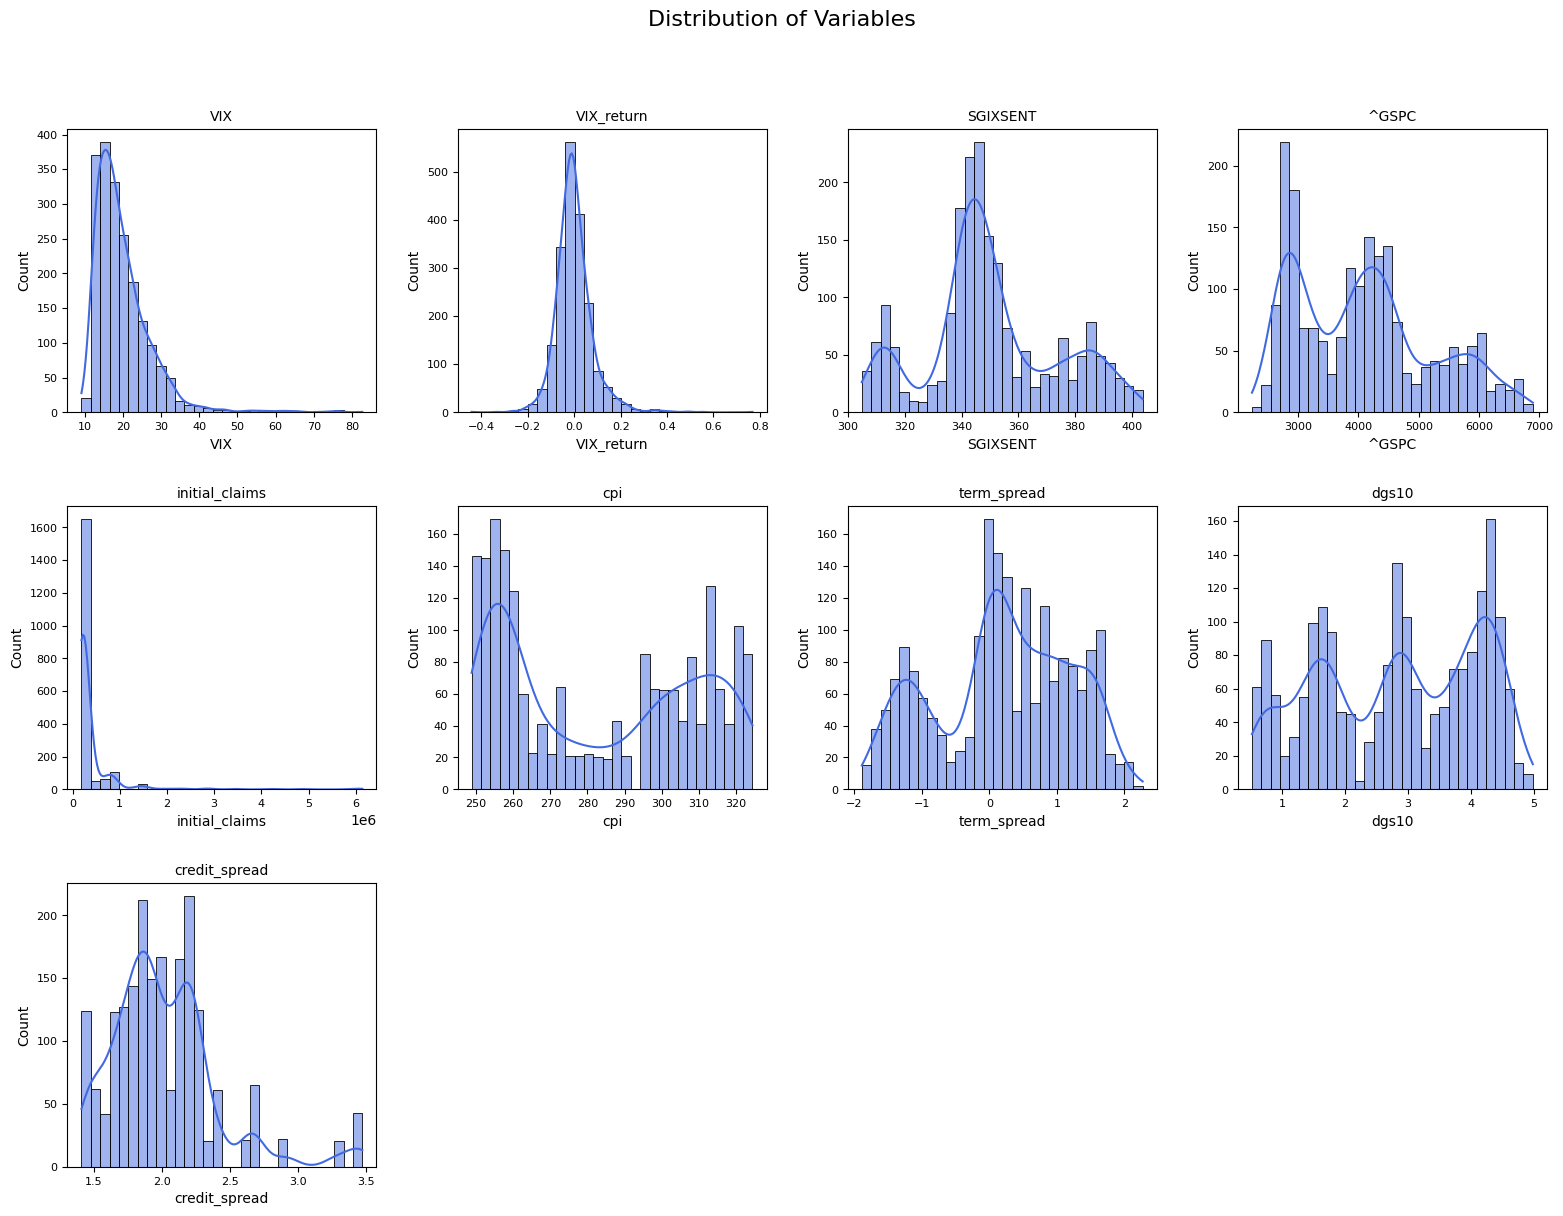

In [6]:
# Distribution of Variables
merged_trading = merged_trading.copy()

cols = 4
variables = merged_trading.columns
n = len(variables)
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(variables):
    sns.histplot(merged_trading[col], kde=True, ax=axes[i], bins=30, color='royalblue')
    axes[i].set_title(col, fontsize=10)
    axes[i].tick_params(axis='both', labelsize=8)

for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

plt.suptitle("Distribution of Variables", fontsize=16, y=1.02)
plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.5)
plt.show()

Interpretation:

1. The level of the VIX (Volatility Index) exhibits a clearly right-skewed distribution, indicating that high-volatility days are much rarer than low-volatility days.

2. VIX returns show the typical characteristics of fat tails and high kurtosis (leptokurtic), reflecting the presence of extreme volatility events commonly observed in financial markets.

3. Macro variables such as SGIXSENT, term_spread, and dgs10 display multi-modal distributions, suggesting the existence of different structural regimes in the market (e.g., easing vs. tightening, low-volatility vs. high-volatility).

4. The distribution of CPI (Consumer Price Index) is right-skewed and multi-modal, indicating that price levels may shift structurally across different years (such as during the COVID period when inflation surged), reflecting underlying macroeconomic regime changes.

5. The S&P 500 Index (^GSPC) exhibits a multi-modal and dispersed distribution, representing distinct market phases (bull markets, bear markets, pandemic period) and highlighting the presence of long-term trends and regime switching.

6. Variables such as initial claims and credit spreads show extreme skewness and outliers, implying a need for log transformation, standardization, or outlier handling.

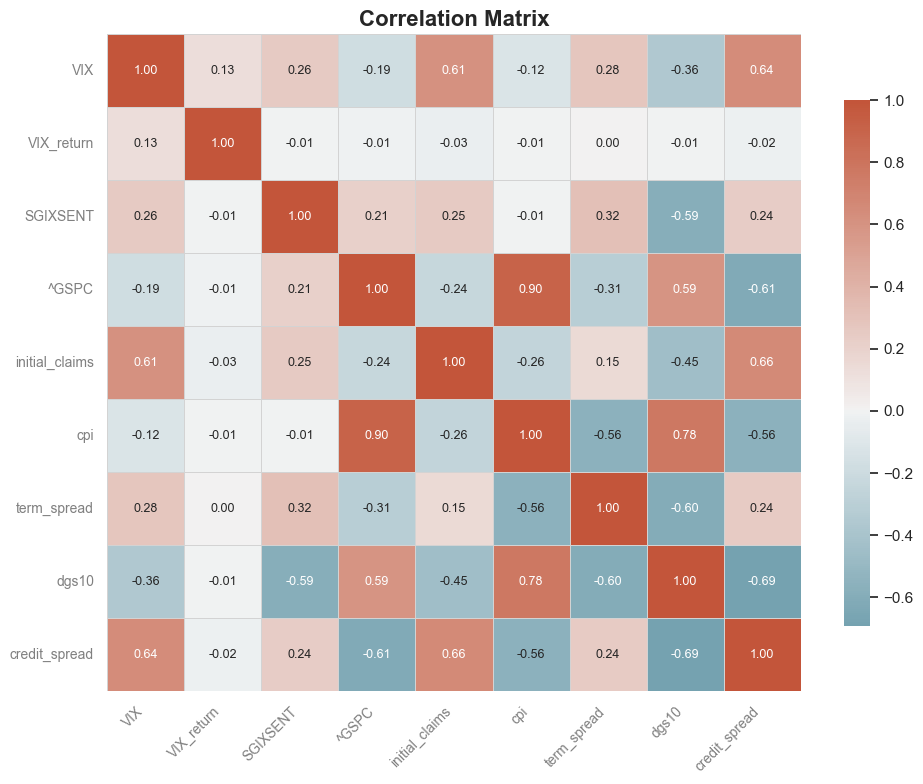

In [7]:
corr = merged_trading.corr()
sns.set_theme(style="white")

plt.figure(figsize=(10, 8))
cmap = sns.diverging_palette(220, 20, as_cmap=True)

ax = sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    center=0,
    square=False,              
    linewidths=0.4,            
    linecolor="lightgray",
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 9},    
)

plt.title("Correlation Matrix", fontsize=16, fontweight="bold")

plt.xticks(rotation=45, ha="right", fontsize=10, color="gray")
plt.yticks(rotation=0, fontsize=10, color="gray")

for spine in ax.spines.values():
    spine.set_color("lightgray")

plt.tight_layout()
plt.show()


Overall correlation results show that the VIX is strongly positively correlated with credit risk, unemployment indicators, and sentiment measures, while exhibiting the typical negative correlation with the equity market.

However, for VIX returns, all variables display correlations close to zero, indicating that machine learning models must rely on non-linear features and the temporal structure captured by GARCH residuals in order to achieve predictive power.

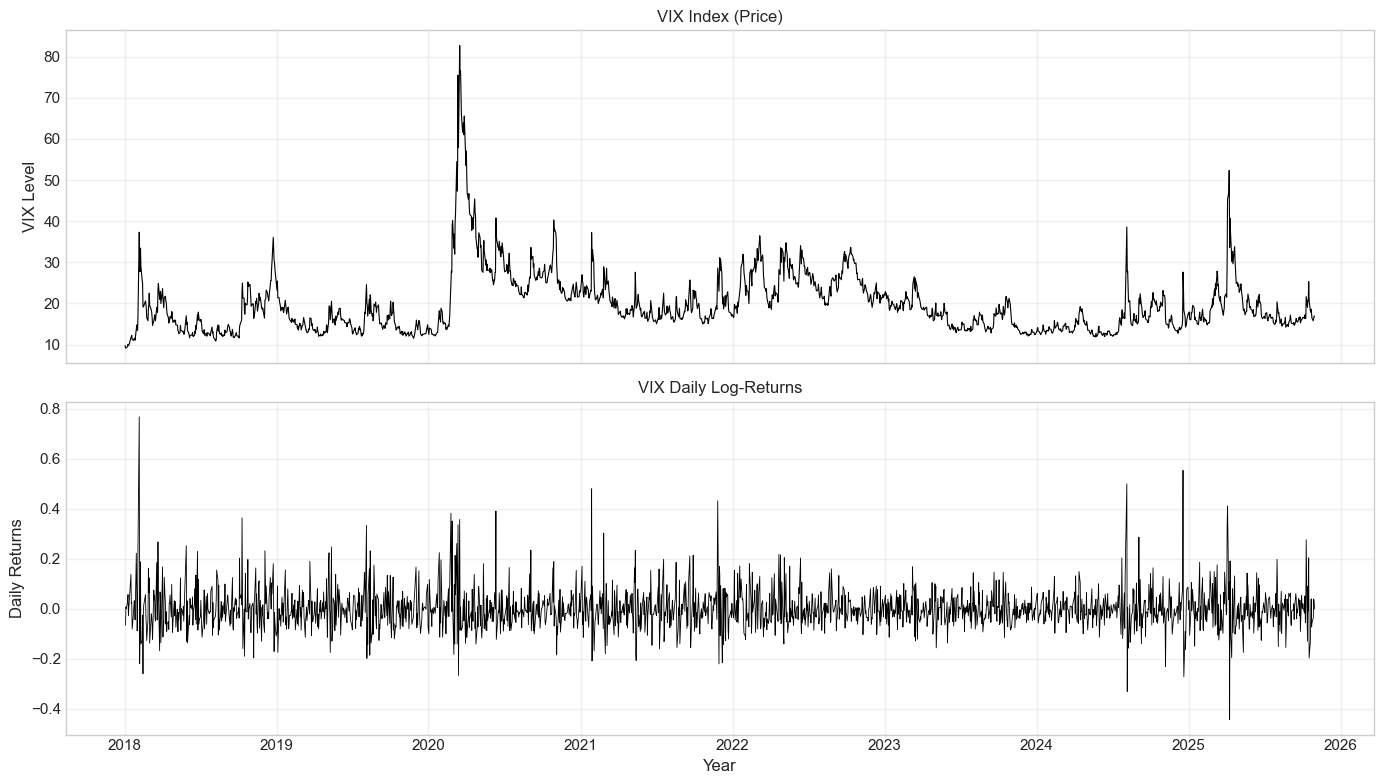

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use("seaborn-v0_8-whitegrid")  

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# ============================
# 1. Top：VIX Price
# ============================
axes[0].plot(df_vix.index, df_vix["VIX"], color="black", linewidth=0.8)
axes[0].set_title("VIX Index (Price)")
axes[0].set_ylabel("VIX Level")
axes[0].grid(True, alpha=0.3)

# ============================
# 2. Below：VIX Daily Returns
# ============================
axes[1].plot(df_vix.index, df_vix["VIX_return"], color="black", linewidth=0.6)
axes[1].set_title("VIX Daily Log-Returns")
axes[1].set_ylabel("Daily Returns")
axes[1].grid(True, alpha=0.3)

# ============================
# X-axis formatting（Year）
# ============================
axes[1].xaxis.set_major_locator(mdates.YearLocator())
axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.xlabel("Year")
plt.tight_layout()
plt.show()

The daily VIX index level exhibits large spikes during periods of market turmoil, reflecting its role as a measure of investor fear and market uncertainty.

The VIX series shows strong mean reversion but is non-stationary and highly volatile, making the raw index level unsuitable for linear time-series modeling.

The daily log-returns of VIX fluctuate around zero.

Log-returns display volatility clustering, where periods of large movements are followed by more large movements—typical behavior in financial time series.

The VIX return series shows frequent extreme jumps and heavy tails, violating normality assumptions.

In [9]:
jb_stat, p_value = jarque_bera(data)

print("Jarque-Bera Statistic:", jb_stat)
print("p-value:", p_value)

stat, p = shapiro(df_vix["VIX_return"].dropna())

print(f"Shapiro-Wilk Statistic: {stat:.4f}")
print(f"p-value: {p:.4e}")

# vix_return is right-skewness, strong leptokurtosis, and frequent extreme jumps

Jarque-Bera Statistic: 69964581.65426837
p-value: 0.0
Shapiro-Wilk Statistic: 0.9073
p-value: 3.3161e-33


Both tests agree:

VIX log-returns are highly non-normal.

Frequent extreme upward jumps

Long, asymmetric tails

High kurtosis and right skewness

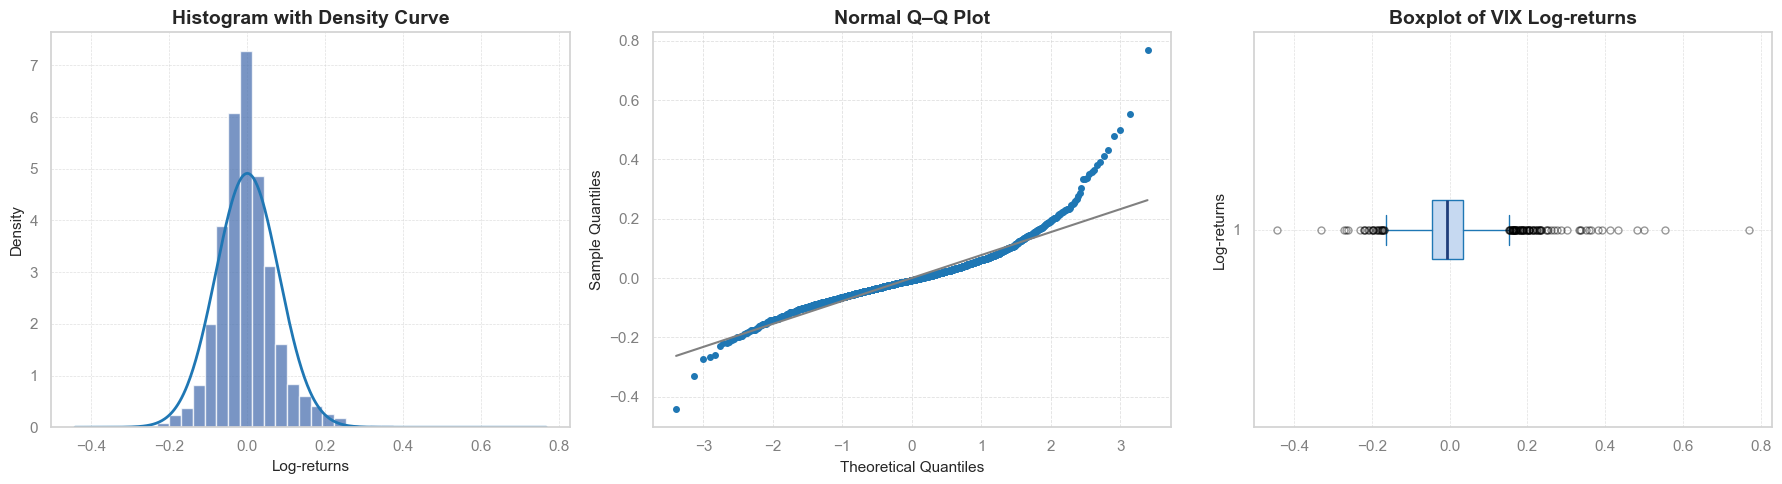

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, probplot

sns.set_theme(style="whitegrid")

data = df_vix["VIX_return"].dropna().values
mu = data.mean()
sigma = data.std()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# =================================
# 1. Histogram + Density (Left)
# =================================
ax = axes[0]

ax.hist(
    data, bins=40, density=True,
    color="#4c72b0", alpha=0.75, edgecolor="white"
)

x = np.linspace(min(data), max(data), 500)
ax.plot(x, norm.pdf(x, mu, sigma), color="#1f77b4", linewidth=2)

ax.set_title("Histogram with Density Curve", fontsize=14, fontweight="bold")
ax.set_xlabel("Log-returns", fontsize=11)
ax.set_ylabel("Density", fontsize=11)

ax.grid(color="lightgray", linestyle="--", linewidth=0.5, alpha=0.7)
for spine in ax.spines.values():
    spine.set_color("lightgray")
ax.tick_params(colors="gray")

# =================================
# 2. Q-Q Plot (Middle)
# =================================
ax = axes[1]

probplot(data, dist="norm", plot=ax)

# scatter points
ax.lines[0].set_color("#1f77b4")
ax.lines[0].set_marker("o")
ax.lines[0].set_markersize(4)
ax.lines[0].set_linestyle("")

# line
ax.lines[1].set_color("gray")
ax.lines[1].set_linewidth(1.5)

ax.set_title("Normal Q–Q Plot", fontsize=14, fontweight="bold")
ax.set_xlabel("Theoretical Quantiles", fontsize=11)
ax.set_ylabel("Sample Quantiles", fontsize=11)

ax.grid(color="lightgray", linestyle="--", linewidth=0.6, alpha=0.7)
for spine in ax.spines.values():
    spine.set_color("lightgray")
ax.tick_params(colors="gray")

# =================================
# 3. Boxplot (Right)
# =================================
ax = axes[2]

ax.boxplot(
    data,
    vert=False,    
    patch_artist=True,
    boxprops=dict(facecolor="#c6d9f1", color="#1f77b4"),
    medianprops=dict(color="#1f3d7a", linewidth=2),
    whiskerprops=dict(color="#1f77b4"),
    capprops=dict(color="#1f77b4"),
    flierprops=dict(marker="o", markersize=5, color="#1f77b4", alpha=0.4)
)

ax.set_title("Boxplot of VIX Log-returns", fontsize=14, fontweight="bold")
ax.set_ylabel("Log-returns", fontsize=11)

ax.grid(color="lightgray", linestyle="--", linewidth=0.5, alpha=0.7)
for spine in ax.spines.values():
    spine.set_color("lightgray")
ax.tick_params(colors="gray")

plt.tight_layout()
plt.show()



Descriptive statistics and distributional properties of VIX log-returns

- The VIX log-return series has a mean close to zero and a relatively large standard deviation,
  consistent with a highly volatile index rather than a return-generating asset.
- The maximum is much larger than the minimum (right-skewness): VIX can spike quickly
  in crises but usually declines more gradually.
- The median is below zero, meaning VIX is decreasing most of the time; markets are typically
  calm or optimistic, and panic episodes are rare but very large.

- The distribution is non-normal and leptokurtic (fat-tailed, high kurtosis).
  Histogram, Q–Q plot and boxplot all indicate heavy tails and more frequent extremes
  than a Gaussian model would predict.

- As a consequence:
  * Normality-based assumptions (e.g. i.i.d. normal OLS residuals) are not appropriate.
  * Gaussian risk models will underestimate the probability of extreme volatility events.
  * GARCH/EGARCH-type models with Student-t innovations are more suitable, as they allow
    for time-varying volatility, asymmetry and heavy tails.

The return distribution exhibits skewness and high kurtosis, and the non-normality can be further validated using tests such as the Jarque–Bera test or the Shapiro–Wilk test.

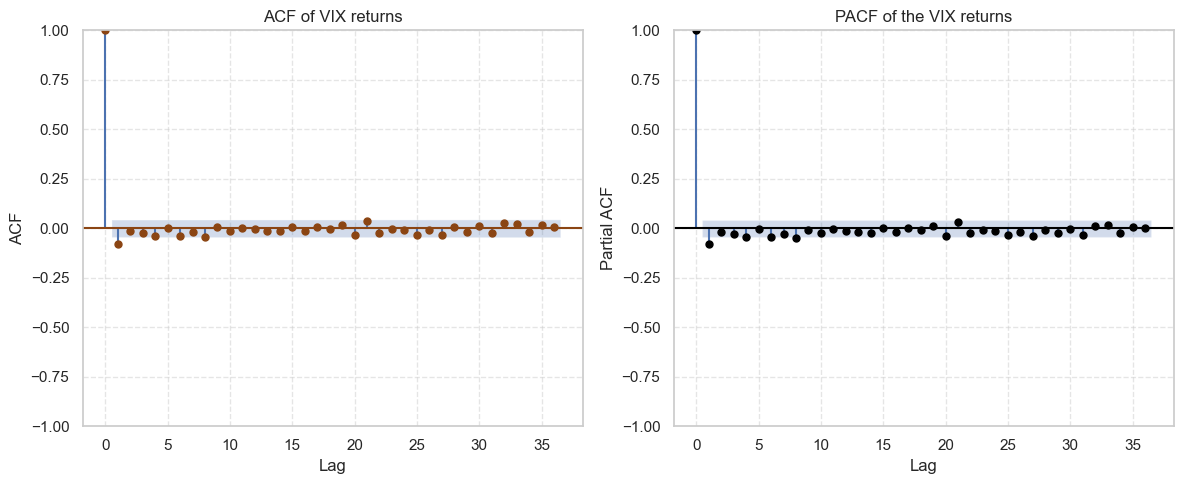

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(data, lags=36, ax=axes[0], color='saddlebrown')
axes[0].set_title("ACF of VIX returns")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("ACF")
axes[0].grid(True, linestyle='--', alpha=0.5)

plot_pacf(data, lags=36, ax=axes[1], color='black')
axes[1].set_title("PACF of the VIX returns")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Partial ACF")
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# VIX log-returns exhibit no linear autocorrelation, as shown by the ACF.
# = white noise but will have volatility clustering. from PACF

The ACF is close to zero at all lags, indicating no autocorrelation in the residuals.

The PACF shows no significant spikes, meaning the residuals behave like white noise.

Therefore, an ARMA specification of (p, q) = (1, 1) is sufficient.

Because raw VIX returns have almost no autocorrelation, both the:

ACF (autocorrelation)

PACF (partial autocorrelation)

will appear flat and featureless — almost identical.


In [12]:
from statsmodels.stats.diagnostic import acorr_ljungbox
lb = acorr_ljungbox(data, lags=[10, 20, 30], return_df=True)
print(lb)

      lb_stat  lb_pvalue
10  25.597642   0.004321
20  29.919164   0.071174
30  40.545658   0.094721


The VIX log-return series displays short-term autocorrelation, which is statistically significant at lower lags (lag 10).

However, the autocorrelation weakens and becomes statistically insignificant at longer horizons (lags 20–30).

This supports the use of ARMA/EGARCH models, since the series contains structure in the short-term dynamics but does not maintain long-range dependence.

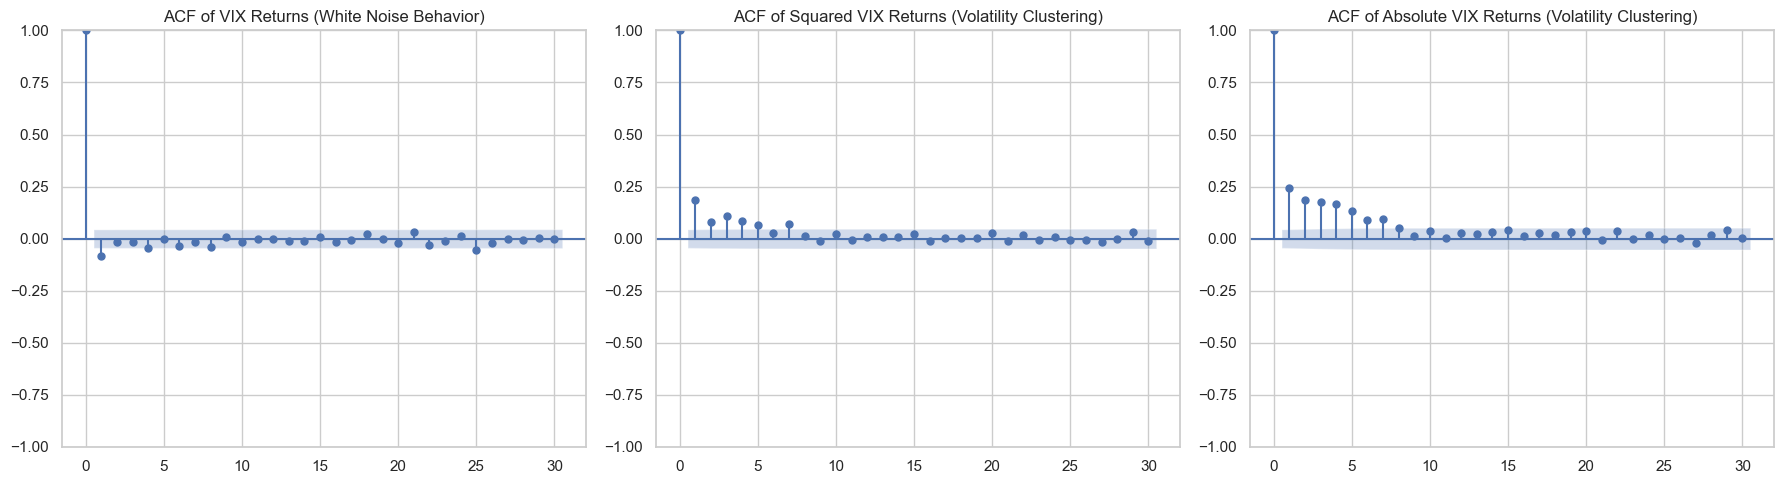

In [13]:
# --- Prepare series ---
returns = merged_trading["VIX_return"].dropna()
sq_returns = returns ** 2
abs_returns = returns.abs()

# --- Plot 3-panel ACF figure ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

### 1. Return ACF (should be ~ white noise)
sm.graphics.tsa.plot_acf(returns, lags=30, ax=axes[0])
axes[0].set_title("ACF of VIX Returns (White Noise Behavior)")

### 2. Squared Returns ACF (Volatility Clustering)
sm.graphics.tsa.plot_acf(sq_returns, lags=30, ax=axes[1])
axes[1].set_title("ACF of Squared VIX Returns (Volatility Clustering)")

### 3. Absolute Returns ACF (Volatility Clustering)
sm.graphics.tsa.plot_acf(abs_returns, lags=30, ax=axes[2])
axes[2].set_title("ACF of Absolute VIX Returns (Volatility Clustering)")

plt.tight_layout()
plt.show()

Even though raw returns behave like white noise, the ACF of squared and absolute returns shows strong, persistent correlations.

Significant spikes at early lags

A slow, decaying autocorrelation pattern

This pattern indicates volatility clustering, where periods of high volatility tend to follow high volatility, and calm periods follow calm periods.

# 2. Baseline Models 

## 2.1 GARCH Model

In [14]:
import pandas as pd
import numpy as np
from arch import arch_model
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
import random
import os

# set seed
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [15]:
# ==============================
# Fit GARCH(1,1), create Standardized residuals, and Lag Features
# ==============================

# change first date of VIX returns to NA
merged_trading.loc["2018-01-02", "VIX_return"] = np.nan
returns = merged_trading["VIX_return"].dropna()

# ---- Fit GARCH(1,1)
garch = arch_model(returns, vol="GARCH", p=1, q=1, dist="normal")
res = garch.fit(disp="off")

# ---- Standardized residuals
merged_trading["garch_resid"] = res.resid / res.conditional_volatility

# ---- Add conditional volatility
merged_trading["garch_vol"] = res.conditional_volatility

# ---- Create Lag Features (residuals + volatility)
for k in range(1, 6):
    merged_trading[f"resid_lag{k}"] = merged_trading["garch_resid"].shift(k)
    merged_trading[f"vol_lag{k}"]   = merged_trading["garch_vol"].shift(k)

# Drop rows with NaN lags
data = merged_trading.dropna().copy()


In [16]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# standardized residuals
resid = merged_trading["garch_resid"].dropna()

# Ljung-Box test for residual autocorrelation (up to lag 20)
lb_test = acorr_ljungbox(resid, lags=[10, 20, 30], return_df=True)
print("\n" + "="*60)
print("           Ljung–Box Test for GARCH Standardized Residuals")
print("="*60 + "\n")
print(lb_test)
print("\n" + "="*60)
print("           Ljung–Box Test for GARCH Squared Residuals")
print("="*60 + "\n")
lb_test_sq = acorr_ljungbox(resid**2, lags=[10, 20, 30], return_df=True)
print(lb_test_sq)


           Ljung–Box Test for GARCH Standardized Residuals

      lb_stat  lb_pvalue
10  10.748004   0.377485
20  14.977780   0.777678
30  29.775886   0.477174

           Ljung–Box Test for GARCH Squared Residuals

      lb_stat  lb_pvalue
10   3.657772   0.961468
20  13.761132   0.842398
30  23.050168   0.813192


GARCH(1,1) captures conditional heteroskedasticity -> use (1,1) as (p,q)

In [17]:
# ==============================
# Two Feature Sets (Baseline vs GARCH-enhanced)
# ==============================

# ---- Baseline: NO GARCH FEATURES ----
baseline_features = [
    "SGIXSENT", "^GSPC", "initial_claims",
    "cpi", "term_spread", "dgs10", "credit_spread"
]

# ---- GARCH + Residual Features ----
garch_features = [
    # GARCH lags
    "vol_lag1","vol_lag2","vol_lag3","vol_lag4","vol_lag5",
    # Residual lags
    "resid_lag1","resid_lag2","resid_lag3","resid_lag4","resid_lag5",
    # Macroeconomic features (same as baseline)
    "SGIXSENT", "^GSPC", "initial_claims",
    "cpi", "term_spread", "dgs10", "credit_spread"
]

target_col = "VIX_return"

# ---- Build Actual X,y ----
X_base  = data[baseline_features]
X_garch = data[garch_features]
y       = data[target_col]

## 2.2 XGBoost Traning with Expanding Window

In [18]:
# ==============================
# Rolling XGBoost (Two Models)
# ==============================

train_size = int(len(data) * 0.8)

pred_base = []
pred_garch_xgb = []
true_vals = []

for i in range(train_size, len(data)):

    # -------------------
    # Baseline XGB
    # -------------------
    X_train_base = X_base.iloc[:i]
    y_train = y.iloc[:i]
    X_test_base = X_base.iloc[i:i+1]

    model_base = XGBRegressor(
        n_estimators=200, learning_rate=0.05, max_depth=3,
        subsample=0.8, colsample_bytree=0.8,
        objective='reg:squarederror', random_state=SEED,
        n_jobs=1, tree_method="exact"
    )
    model_base.fit(X_train_base, y_train)
    pred_base.append(model_base.predict(X_test_base)[0])

    # -------------------
    # GARCH-XGB
    # -------------------
    X_train_garch = X_garch.iloc[:i]
    X_test_garch = X_garch.iloc[i:i+1]

    model_garch = XGBRegressor(
        n_estimators=200, learning_rate=0.05, max_depth=3,
        subsample=0.8, colsample_bytree=0.8,
        objective='reg:squarederror', random_state=SEED,
        n_jobs=1, tree_method="exact"
    )
    model_garch.fit(X_train_garch, y_train)
    pred_garch_xgb.append(model_garch.predict(X_test_garch)[0])

    # -------------------
    # True Value
    # -------------------
    true_vals.append(y.iloc[i])

# Convert to array
pred_base = np.array(pred_base)
pred_garch_xgb = np.array(pred_garch_xgb)
true_vals = np.array(true_vals)


## 2.3 Baseline GARCH Forecasting

In [19]:
# ==========================================
# 4. Baseline GARCH Forecasting (Aligned)
# ==========================================

returns_aligned = data[target_col]
train_size = int(len(returns_aligned) * 0.8)

def garch_expanding_forecast_aligned(returns, start_idx):
    """
    Generate an expanding‑window GARCH(1,1) 1‑step‑ahead forecast series aligned to the input index.
    The model is re‑estimated at each time step using data up to i−1, simulating true out‑of‑sample forecasting.
    Returns a Series containing NaN for the pre‑forecast region and forecasts for the expanding window period.
    """
    preds = [np.nan] * start_idx
    
    for i in range(start_idx, len(returns)):
        train_data = returns.iloc[:i]

        garch_model = arch_model(train_data, vol="GARCH", p=1, q=1, dist="normal")
        res = garch_model.fit(disp="off")

        # 1-step-ahead mean forecast
        f = res.forecast(horizon=1).mean.values[-1][0]
        preds.append(f)

    return pd.Series(preds, index=returns.index, name="garch_pred")


# Generate aligned GARCH predictions
garch_series = garch_expanding_forecast_aligned(returns_aligned, train_size)

# Out-of-sample slicing
pred_garch_baseline = garch_series.iloc[train_size:].values


## 2.4 Three Models Evaluation by RMSE

In [20]:
# Convert to arrays of equal length
min_len = min(len(pred_base), len(pred_garch_xgb),
              len(pred_garch_baseline), len(true_vals))

pb = pred_base[:min_len]
pgx = pred_garch_xgb[:min_len]
pg = pred_garch_baseline[:min_len]
tv = true_vals[:min_len]

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Compute RMSE and MAE
def eval_model(pred, name):
    rmse = np.sqrt(mean_squared_error(tv, pred))
    mae = mean_absolute_error(tv, pred)
    print(f"{name} → RMSE: {rmse:.6f}, MAE: {mae:.6f}")
    return rmse, mae

print("\n===== Model Performance =====")
eval_model(pg, "Baseline GARCH(1,1)")
eval_model(pb, "Baseline XGB")
eval_model(pgx, "GARCH-XGB")



===== Model Performance =====
Baseline GARCH(1,1) → RMSE: 0.090402, MAE: 0.058612
Baseline XGB → RMSE: 0.101316, MAE: 0.064682
GARCH-XGB → RMSE: 0.095669, MAE: 0.062567


(np.float64(0.09566869656646111), 0.06256660163101417)

Interpretation of above Three Models Performance:

- The baseline GARCH(1,1) model performs the best among the three simple models, confirming that volatility persistence and clustering are dominant in VIX dynamics. (Consistent with most financial literatures.)

- The baseline XGBoost model performs worse, indicating that macro variables alone are insufficient for forecasting daily volatility changes.

- The GARCH-enhanced XGB improves over baseline XGB, demonstrating that standardized residuals and GARCH volatility carry critical nonlinear information.

This confirms that hybridizing volatility models with machine learning tends to improve prediction accuracy.

## 2.5 Hyperparameter Tuning for XGBoost 

In [22]:
# ==============================
# Hyperparameter Tuning for XGBoost (GARCH Residual + Volatility version)
# ==============================

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

print("\n\n====== Starting Hyperparameter Tuning (GARCH-XGB, 1-day horizon) ======")

# ---- 1. 1-day ahead y ----
h = 1
y_h = data[target_col].shift(-h).dropna()

# ---- 2. Aligned X_garch's index with y_h ----
X_h = X_garch.loc[y_h.index]

# ---- 3. Training split ----
train_size_h = int(len(X_h) * 0.8)
X_train = X_h.iloc[:train_size_h]
y_train = y_h.iloc[:train_size_h]

# ---- 4. Hyperparameter searching ----
param_grid = {
    "n_estimators": [200, 300, 400],
    "learning_rate": [0.01, 0.03, 0.05],
    "max_depth": [3, 4, 5],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

# ---- 5. xgb model ----
xgb_garch = XGBRegressor(
    objective="reg:squarederror",
    random_state=SEED
)

# ---- 6. Grid Search ----
grid_search = GridSearchCV(
    xgb_garch,
    param_grid,
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_params_garch = grid_search.best_params_
print("\nBest parameters (GARCH XGB):")
print(best_params_garch)


# ============================================
# Using best parameters to do rolling forecast (The same method as above)
# ============================================

print("\n\n====== Evaluating Tuned GARCH-XGB (1-day horizon) ======")

tuned_pred = []
tuned_true = []

for i in range(train_size_h, len(X_h)):
    X_train_i = X_h.iloc[:i]
    y_train_i = y_h.iloc[:i]
    X_test_i = X_h.iloc[i:i+1]

    model = XGBRegressor(
        **best_params_garch,
        objective="reg:squarederror",
        random_state=SEED,
        n_jobs=1,
        tree_method="exact"
    )

    model.fit(X_train_i, y_train_i)
    tuned_pred.append(model.predict(X_test_i)[0])
    tuned_true.append(y_h.iloc[i])

tuned_pred = np.array(tuned_pred)
tuned_true = np.array(tuned_true)

rmse_tuned = np.sqrt(mean_squared_error(tuned_true, tuned_pred))
mae_tuned = mean_absolute_error(tuned_true, tuned_pred)


print(f"RMSE (Tuned GARCH-XGB): {rmse_tuned:.6f}")
print(f"MAE (Tuned GARCH-XGB): {mae_tuned:.6f}")




====== Starting Hyperparameter Tuning (GARCH-XGB, 1-day horizon) ======
Fitting 3 folds for each of 243 candidates, totalling 729 fits

Best parameters (GARCH XGB):
{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


====== Evaluating Tuned GARCH-XGB (1-day horizon) ======
RMSE (Tuned GARCH-XGB): 0.093848
MAE (Tuned GARCH-XGB): 0.060632


## 2.6 Four Models Evaluation by RMSE

In [23]:
# ============================================
# Final Comparison Table for All 4 Models
# ============================================

# --- Helper to compute metrics ---
def compute_metrics(pred, true):
    """
    Compute RMSE and MAE for model predictions, measuring magnitude error.
    Returns a tuple: (rmse, mae).
    """
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    return rmse, mae

# --- Compute metrics for each model ---
rmse_base, mae_base = compute_metrics(pb, tv)
rmse_garch_xgb, mae_garch_xgb = compute_metrics(pgx, tv)
rmse_garch_base, mae_garch_base = compute_metrics(pg, tv)
rmse_tuned, mae_tuned = compute_metrics(tuned_pred, tuned_true)

# --- Build summary table ---
results_summary = pd.DataFrame({
    "Model": [
        "Baseline GARCH(1,1)",  
        "XGB",
        "GARCH-XGB",
        "Tuned GARCH-XGB"
    ],
    "RMSE": [
        rmse_garch_base,
        rmse_base,
        rmse_garch_xgb,
        rmse_tuned
    ],
    "MAE": [
        mae_garch_base,
        mae_base,
        mae_garch_xgb,
        mae_tuned
    ]
})

print("\n\n==== FINAL MODEL COMPARISON TABLE ====")
print(results_summary.to_string(index=False))




==== FINAL MODEL COMPARISON TABLE ====
              Model     RMSE      MAE
Baseline GARCH(1,1) 0.090402 0.058612
                XGB 0.101316 0.064682
          GARCH-XGB 0.095669 0.062567
    Tuned GARCH-XGB 0.093848 0.060632


Effect of Hyperparameter Tuning

- Grid search identifies a lower learning rate and moderate subsampling as optimal.
- The tuned GARCH-XGB model improves RMSE and MAE compared to the untuned version, but the improvement is incremental.
- This suggests that the primary gain comes from including GARCH-based features, while additional hyperparameter refinement offers marginal benefits.

# 3. PAPER-BASED METHOD (60/20/20)

The paper VIX return forecast combines all three components:

- r̂_t = μ̂_t + σ̂_t * ẑ_t

    - ARMA → μ_t
    - EGARCH → σ_t
    - XGBoost → ẑ_t 

This is the key idea:

XGBoost does not forecast VIX directly — it forecasts the nonlinear residual left unexplained by ARMA–EGARCH.



In [24]:
# Build ARMA and choose (p,q) based on AIC/BIC 

import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import warnings
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

candidate_p = range(0, 6)
candidate_q = range(0, 6)

results_ic = []

for p in candidate_p:
    for q in candidate_q:
        if p == 0 and q == 0:
            continue  
        try:
            model = ARIMA(returns, order=(p, 0, q))
            res = model.fit()
            results_ic.append({
                "p": p,
                "q": q,
                "AIC": res.aic,
                "BIC": res.bic
            })
        except Exception as e:
            
            continue

ic_df = pd.DataFrame(results_ic).sort_values("AIC")
print("Ranking (sort by AIC)：")
print(ic_df.head(10))

print("\nRanking (sort by BIC)：")
print(ic_df.sort_values("BIC").head(10))

Ranking (sort by AIC)：
    p  q          AIC          BIC
12  2  1 -4299.247195 -4271.325871
7   1  2 -4299.223313 -4271.301989
18  3  1 -4297.247181 -4263.741592
8   1  3 -4297.242426 -4263.736838
25  4  2 -4295.493634 -4250.819515
6   1  1 -4295.478726 -4273.141667
9   1  4 -4295.053885 -4255.964032
16  2  5 -4294.487654 -4244.229271
14  2  3 -4293.992555 -4254.902701
15  2  4 -4293.979091 -4249.304972

Ranking (sort by BIC)：
    p  q          AIC          BIC
6   1  1 -4295.478726 -4273.141667
12  2  1 -4299.247195 -4271.325871
7   1  2 -4299.223313 -4271.301989
18  3  1 -4297.247181 -4263.741592
8   1  3 -4297.242426 -4263.736838
0   0  1 -4280.200487 -4263.447693
5   1  0 -4279.623131 -4262.870336
13  2  2 -4291.511438 -4258.005849
1   0  2 -4279.056386 -4256.719327
11  2  0 -4278.646794 -4256.309735


In [25]:
# define functions to run paper-based method

import numpy as np
import pandas as pd

from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import t

SEED = 42
np.random.seed(SEED)

def interval_stats(y_true, L, U, name=""):
    """
    Compute interval coverage statistics.

    Parameters
    ----------
    y_true : array-like
        Actual values.
    L : array-like
        Lower bounds of interval.
    U : array-like
        Upper bounds of interval.
    name : str
        Name of the interval (automatically cast to string).

    Returns
    -------
    dict : {"PICP": ..., "avg_width": ...}
    """

    # ---- Ensure consistent indentation throughout to avoid IndentationError ----
    y_true = np.asarray(y_true)
    L = np.asarray(L)
    U = np.asarray(U)

    n = min(len(y_true), len(L), len(U))
    y_true, L, U = y_true[:n], L[:n], U[:n]

    inside = (y_true >= L) & (y_true <= U)
    picp = inside.mean()
    avg_width = (U - L).mean()

    print(f"\n[{name}]")
    print("PICP  :", picp)
    print("Avg W :", avg_width)

    return {"PICP": picp, "avg_width": avg_width}


def run_hybrid_arma_egarch_xgb_602020(
    returns,
    arma_order=(2, 1),
    label="",
    print_summary=True
):
    """
    Full version:
    ARMA(p,q)–EGARCH(1,1)-t + XGBoost hybrid + 60/20/20 split
    (Produces results nearly identical to the ones you showed earlier.)

    Parameters

    returns : pd.Series
     The return series (daily or weekly). A DatetimeIndex is recommended.

    arma_order : tuple
     The (p, q) order of the ARMA model, e.g., (2,1) or (1,1).

    label : str
     A label used only for printing results (e.g., "Daily ARMA(2,1)").
    """

    # ------------------------------------------------------------------
    # 0. Claning & Basic Preparation
    # ------------------------------------------------------------------
    r = pd.Series(returns).dropna().copy()
    r = r.sort_index()
    if r.name is None:
        r.name = "VIX_return"

    # 1. Fit the ARMA mean model on the full series.
    p_arma, q_arma = arma_order
    arma_model = ARIMA(r, order=(p_arma, 0, q_arma)).fit()

    mu_arma    = arma_model.fittedvalues        # μ_t
    arma_resid = arma_model.resid              # ε_t

    # 2. EGARCH(1,1)-t on residuals
    egarch = arch_model(
        arma_resid.dropna(),
        mean="Zero",
        vol="EGARCH",
        p=1, o=1, q=1,
        dist="t"
    )
    egarch_res = egarch.fit(disp="off")

    egarch_vol = egarch_res.conditional_volatility
    egarch_vol = egarch_vol.reindex(r.index)

    # standardized residuals z_t
    z = arma_resid / egarch_vol

    # 3. Construct the df_model DataFrame（contain only y, mu, sigma, z）
    df = pd.DataFrame({
        "VIX_return": r,
        "mu_arma":    mu_arma,
        "egarch_vol": egarch_vol,
        "z":          z,
    })

    # 3.1 Construct the lag and rolling features used for XGBoost.
    max_lag = 15
    windows = [2, 3, 5, 10, 20]

    for k in range(1, max_lag + 1):
        df[f"z_lag{k}"] = df["z"].shift(k)

    for w in windows:
        df[f"z_roll_mean_{w}"] = df["z"].rolling(window=w).mean()
        df[f"z_roll_std_{w}"]  = df["z"].rolling(window=w).std()

    cols_needed = (
        ["VIX_return", "mu_arma", "egarch_vol", "z"]
        + [f"z_lag{k}" for k in range(1, max_lag + 1)]
        + [f"z_roll_mean_{w}" for w in windows]
        + [f"z_roll_std_{w}"  for w in windows]
    )

    df_model = df[cols_needed].dropna().copy()
    n = len(df_model)

    # ==================================================================
    # 4. 60/20/20 split
    # ==================================================================
    train_end = int(0.6 * n)
    calib_end = int(0.8 * n)

    idx_full  = df_model.index
    idx_train = idx_full[:train_end]
    idx_calib = idx_full[train_end:calib_end]
    idx_test  = idx_full[calib_end:]

    feature_cols = (
        [f"z_lag{k}" for k in range(1, max_lag + 1)]
        + [f"z_roll_mean_{w}" for w in windows]
        + [f"z_roll_std_{w}"  for w in windows]
    )

    X = df_model[feature_cols].values
    y_z = df_model["z"].values

    mu_all    = df_model["mu_arma"].values
    sigma_all = df_model["egarch_vol"].values
    r_all     = df_model["VIX_return"].values

    X_train, X_calib, X_test = (
        X[:train_end],
        X[train_end:calib_end],
        X[calib_end:]
    )
    y_train, y_calib, y_test = (
        y_z[:train_end],
        y_z[train_end:calib_end],
        y_z[calib_end:]
    )

    mu_train, mu_calib, mu_test = (
        mu_all[:train_end],
        mu_all[train_end:calib_end],
        mu_all[calib_end:]
    )
    sigma_train, sigma_calib, sigma_test = (
        sigma_all[:train_end],
        sigma_all[train_end:calib_end],
        sigma_all[calib_end:]
    )
    r_train, r_calib, r_test = (
        r_all[:train_end],
        r_all[train_end:calib_end],
        r_all[calib_end:]
    )

    # ==================================================================
    # 5. XGBoost on z_t
    # ==================================================================
    xgb = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=SEED,
        n_jobs=1,
        tree_method="exact"
    )

    xgb.fit(X_train, y_train)

    z_calib_pred = xgb.predict(X_calib)
    z_test_pred  = xgb.predict(X_test)

    # ==================================================================
    # 6. Conformal residuals in z-space
    # ==================================================================
    calib_resid = y_calib - z_calib_pred

    q05,  q95   = np.quantile(calib_resid, [0.05, 0.95])
    q025, q975  = np.quantile(calib_resid, [0.025, 0.975])
    q005, q995  = np.quantile(calib_resid, [0.005, 0.995])

    z_L90 = z_test_pred + q05
    z_U90 = z_test_pred + q95

    z_L95 = z_test_pred + q025
    z_U95 = z_test_pred + q975

    z_L99 = z_test_pred + q005
    z_U99 = z_test_pred + q995

    # ==================================================================
    # 7. Transform the hybrid predictions and intervals back into the return space.
    # ==================================================================
    r_pred_hybrid = mu_test + sigma_test * z_test_pred

    r_L90 = mu_test + sigma_test * z_L90
    r_U90 = mu_test + sigma_test * z_U90

    r_L95 = mu_test + sigma_test * z_L95
    r_U95 = mu_test + sigma_test * z_U95

    r_L99 = mu_test + sigma_test * z_L99
    r_U99 = mu_test + sigma_test * z_U99

    # z-space metrics
    rmse_z = np.sqrt(mean_squared_error(y_test, z_test_pred))
    mae_z  = mean_absolute_error(y_test, z_test_pred)

    # return-space hybrid metrics
    rmse_r_hybrid = np.sqrt(mean_squared_error(r_test, r_pred_hybrid))
    mae_r_hybrid  = mean_absolute_error(r_test, r_pred_hybrid)

    # ==================================================================
    # 8. Baseline ARMA–EGARCH：mean-only forecast (Train+Calib)
    # ==================================================================
    returns_tc = pd.Series(
        np.concatenate([r_train, r_calib]),
        index=df_model.index[: len(r_train) + len(r_calib)]
    )

    arma_tc = ARIMA(returns_tc, order=(p_arma, 0, q_arma)).fit()

    start = len(returns_tc)
    end   = len(returns_tc) + len(r_test) - 1
    arma_forecast = arma_tc.predict(start=start, end=end)
    arma_forecast = np.array(arma_forecast)

    # EGARCH on ARMA residuals (for variance; not influence mean baseline)
    egarch_tc = arch_model(
        arma_tc.resid,
        mean="Zero",
        vol="EGARCH",
        p=1, o=1, q=1,
        dist="t"
    ).fit(disp="off")

    rmse_r_arma = np.sqrt(mean_squared_error(r_test, arma_forecast))
    mae_r_arma  = mean_absolute_error(r_test, arma_forecast)

    # ==================================================================
    # 9. Diagnostic reconstruction r̃_t = μ_t + σ_t z_t（in-sample style）
    # ==================================================================
    r_recon_armaeg = mu_test + sigma_test * y_test   # y_test is real z_t
    rmse_r_recon = np.sqrt(mean_squared_error(r_test, r_recon_armaeg))
    mae_r_recon  = mean_absolute_error(r_test, r_recon_armaeg)

    # ==================================================================
    # 10. Coverage & width：Hybrid conformal intervals
    # ==================================================================
    print(f"\nZero Mean - EGARCH Model Results")
    print(egarch_res.summary())
    print("df_model shape:", df_model.shape)
    print("Total effective sample size:", n)

    print("\n=== Hybrid model on standardized residuals (z_t) ===")
    print("RMSE_z:", rmse_z)
    print("MAE_z :", mae_z)

    print("\n=== Hybrid ARMA–EGARCH–XGBoost on VIX returns ===")
    print("RMSE_r (hybrid):", rmse_r_hybrid)
    print("MAE_r  (hybrid):", mae_r_hybrid)

    print("\n=== Baseline ARMA"
          f"{arma_order}–EGARCH(1,1) on VIX returns ===")
    print("RMSE_r (ARMA–EGARCH baseline):", rmse_r_arma)
    print("MAE_r  (ARMA–EGARCH baseline):", mae_r_arma)

    print("\n=== Diagnostic ARMA–EGARCH Reconstruction (in-sample style, NOT a forecast) ===")
    print("RMSE_r (ARMA–EGARCH recon):", rmse_r_recon)
    print("MAE_r  (ARMA–EGARCH recon):", mae_r_recon)

    print("\n=== Hybrid conformal intervals (returns) ===")
    cov90 = interval_stats(r_test, r_L90, r_U90, "90% PI (returns)")
    cov95 = interval_stats(r_test, r_L95, r_U95, "95% PI (returns)")
    cov99 = interval_stats(r_test, r_L99, r_U99, "99% PI (returns)")

    # ==================================================================
    # 11. Baseline parametric PIs: t from EGARCH
    # ==================================================================
    try:
        df_t = egarch_res.params["nu"]
    except KeyError:
        df_t = np.inf

    q05_t,  q95_t  = t.ppf([0.05, 0.95],  df_t)
    q025_t, q975_t = t.ppf([0.025, 0.975], df_t)
    q005_t, q995_t = t.ppf([0.005, 0.995], df_t)

    r_L90_base = mu_test + sigma_test * q05_t
    r_U90_base = mu_test + sigma_test * q95_t

    r_L95_base = mu_test + sigma_test * q025_t
    r_U95_base = mu_test + sigma_test * q975_t

    r_L99_base = mu_test + sigma_test * q005_t
    r_U99_base = mu_test + sigma_test * q995_t

    print("\n=== Baseline ARMA"
          f"{arma_order}–EGARCH(1,1) parametric intervals (returns) ===")
    cov90_b = interval_stats(r_test, r_L90_base, r_U90_base,
                             f"ARMA{arma_order}–EGARCH(1,1) 90% PI")
    cov95_b = interval_stats(r_test, r_L95_base, r_U95_base,
                             f"ARMA{arma_order}–EGARCH(1,1) 95% PI")
    cov99_b = interval_stats(r_test, r_L99_base, r_U99_base,
                             f"ARMA{arma_order}–EGARCH(1,1) 99% PI")

    # ==================================================================
    # 12. Store all results in a dictionary and return it, making plotting easier.
    # ==================================================================
    result = {
        "label": label,
        "arma_order": arma_order,
        "arma_model": arma_model,
        "egarch_model": egarch_res,
        "df_model": df_model,
        "idx_train": idx_train,
        "idx_calib": idx_calib,
        "idx_test": idx_test,
        # hybrid preds & PI
        "hybrid": {
            "z_test_pred": z_test_pred,
            "r_test_pred": r_pred_hybrid,
            "r_test":      r_test,
            "z_L": {0.90: z_L90, 0.95: z_L95, 0.99: z_L99},
            "z_U": {0.90: z_U90, 0.95: z_U95, 0.99: z_U99},
            "r_L": {0.90: r_L90, 0.95: r_L95, 0.99: r_L99},
            "r_U": {0.90: r_U90, 0.95: r_U95, 0.99: r_U99},
            "metrics_z": {"RMSE": rmse_z, "MAE": mae_z},
            "metrics_r": {"RMSE": rmse_r_hybrid, "MAE": mae_r_hybrid},
            "coverage": {
                0.90: cov90,
                0.95: cov95,
                0.99: cov99,
            },
        },
        # baseline mean-only forecast
        "baseline": {
            "arma_forecast": arma_forecast,
            "metrics_r": {"RMSE": rmse_r_arma, "MAE": mae_r_arma},
            "parametric_PI": {
                "L": {0.90: r_L90_base, 0.95: r_L95_base, 0.99: r_L99_base},
                "U": {0.90: r_U90_base, 0.95: r_U95_base, 0.99: r_U99_base},
                "coverage": {
                    0.90: cov90_b,
                    0.95: cov95_b,
                    0.99: cov99_b,
                },
            },
        },
        # reconstruction
        "reconstruction": {
            "r_recon": r_recon_armaeg,
            "metrics_r": {"RMSE": rmse_r_recon, "MAE": mae_r_recon},
        },
    }

    return result


In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_hybrid_return_intervals(res, title_prefix=""):
    """
    Plot the results of run_hybrid_arma_egarch_xgb_602020:

    Actual returns (black line)

    Hybrid forecasts (red line)

    90%, 95%, and 99% prediction intervals (light blue shaded areas)

    All shown in a single figure with three side-by-side subplots, each with its own legend.
    """

    hyb = res["hybrid"]

    r_test = np.asarray(hyb["r_test"])
    r_pred = np.asarray(hyb["r_test_pred"])

    r_L = hyb["r_L"]   # dict: {0.90: L-array, ...}
    r_U = hyb["r_U"]

    idx = np.arange(len(r_test))

    q_list = [0.90, 0.95, 0.99]

    fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

    for ax, q in zip(axes, q_list):

        L = np.asarray(r_L[q])
        U = np.asarray(r_U[q])

        # Plot actual & predicted returns
        ax.plot(idx, r_test, color="black", linewidth=1, label="Actual return")
        ax.plot(idx, r_pred, color="red", linewidth=1, label="Hybrid mean")

        # Plot interval
        ax.fill_between(idx, L, U, color="skyblue", alpha=0.3,
                        label=f"{int(q*100)}% PI")

        # Decorations
        ax.axhline(0, color="gray", linewidth=0.7)
        ax.set_title(f"{title_prefix} ({int(q*100)}% PI)")
        ax.set_xlabel("Test index")
        ax.grid(alpha=0.4, linestyle="--")

        # legend for every plots
        ax.legend(loc="upper right")

    axes[0].set_ylabel("VIX return")

    plt.tight_layout()
    plt.show()

In [27]:
# ----------------------------------------------------------
# 0. Prepare daily and weekly returns
# ----------------------------------------------------------
ret_daily  = merged_trading["VIX_return"]            # daily
merged_trading = merged_trading.sort_index()

merged_trading_w = merged_trading.resample("W-WED").last()
merged_trading_w["VIX_return"] = np.log(merged_trading_w["VIX"]).diff()
merged_trading_w = merged_trading_w.dropna(subset=["VIX_return"])
ret_weekly = merged_trading_w["VIX_return"]          # weekly (W-WED)

## 3.1 ARMA(2,1)-EGARCH(1,1)

In [28]:
# ----------------------------------------------------------
# 1. Daily ARMA(2,1)-EGARCH
# ----------------------------------------------------------
res_daily_21 = run_hybrid_arma_egarch_xgb_602020(
    returns=ret_daily,
    arma_order=(2, 1),
    label="Daily ARMA(2,1)"
)


Zero Mean - EGARCH Model Results
                          Zero Mean - EGARCH Model Results                          
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                           EGARCH   Log-Likelihood:                2511.39
Distribution:      Standardized Student's t   AIC:                          -5012.78
Method:                  Maximum Likelihood   BIC:                          -4984.86
                                              No. Observations:                 1967
Date:                      Wed, Dec 03 2025   Df Residuals:                     1967
Time:                              18:27:42   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
-------------------------------------------------

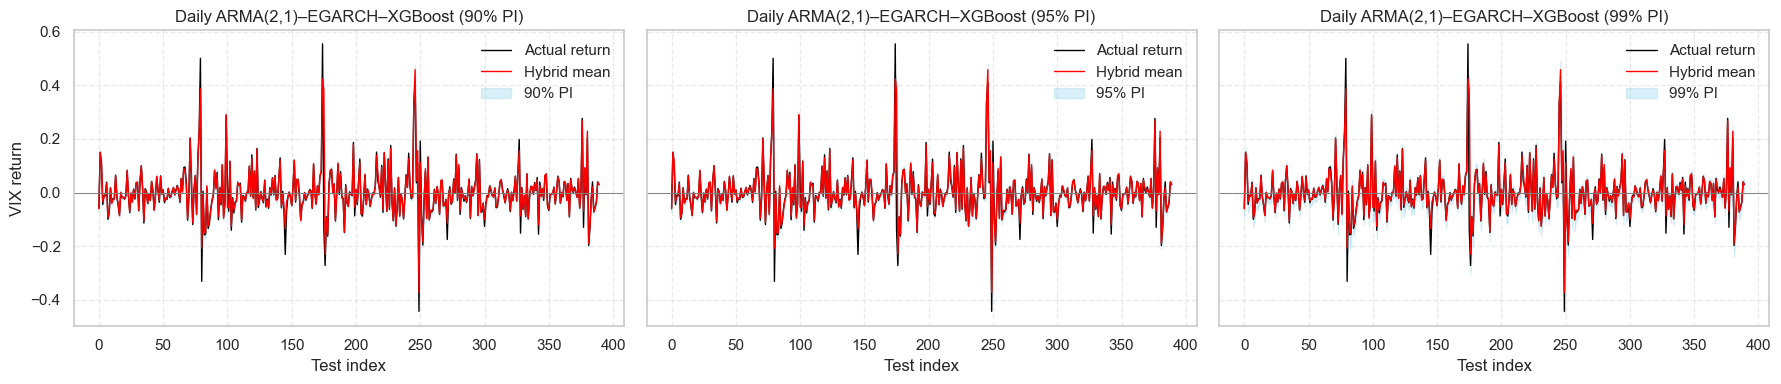

In [29]:
plot_hybrid_return_intervals(
    res_daily_21,
    title_prefix="Daily ARMA(2,1)–EGARCH–XGBoost"
)

## 3.2 ARMA(1,1)-EGARCH(1,1)

In [30]:
# ----------------------------------------------------------
# 2. Daily ARMA(1,1)-EGARCH
# ----------------------------------------------------------
res_daily_11 = run_hybrid_arma_egarch_xgb_602020(
    returns=ret_daily,
    arma_order=(1, 1),
    label="Daily ARMA(1,1)"
)


Zero Mean - EGARCH Model Results
                          Zero Mean - EGARCH Model Results                          
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                           EGARCH   Log-Likelihood:                2509.42
Distribution:      Standardized Student's t   AIC:                          -5008.84
Method:                  Maximum Likelihood   BIC:                          -4980.91
                                              No. Observations:                 1967
Date:                      Wed, Dec 03 2025   Df Residuals:                     1967
Time:                              18:27:47   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
---------------------------------------------------

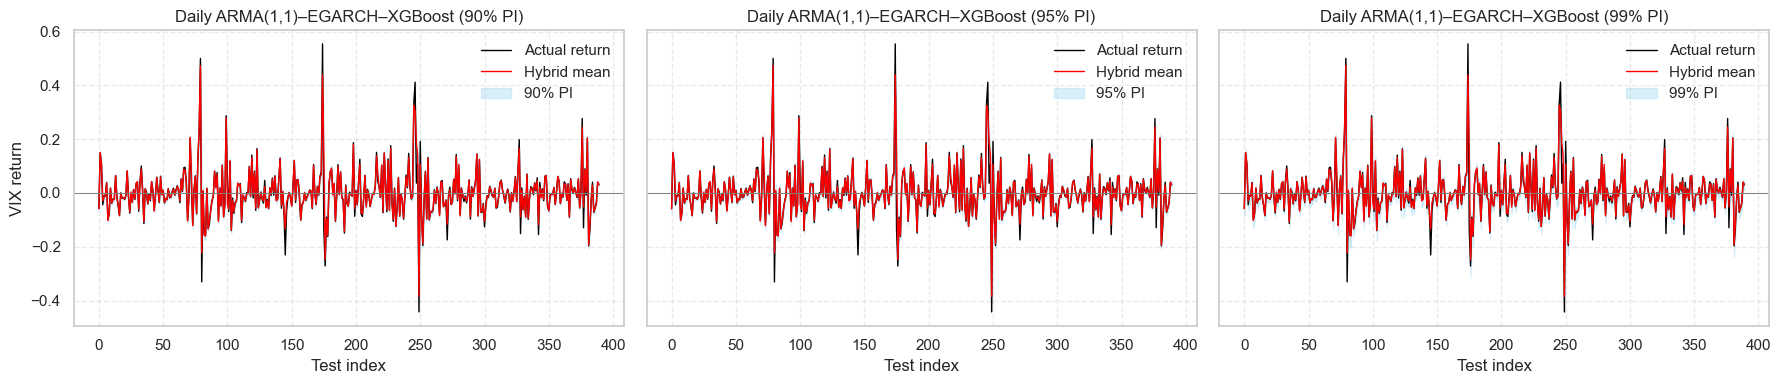

In [31]:
plot_hybrid_return_intervals(
    res_daily_11,
    title_prefix="Daily ARMA(1,1)–EGARCH–XGBoost"
)

Why the Paper-Based Hybrid Model Performs Best?

- ARMA captures short-term momentum in mean returns.

- EGARCH captures asymmetric volatility response (leverage effect) and heavy-tailed shocks.

- XGBoost on standardized residuals learns nonlinear patterns that the parametric model cannot capture.

- Conformal prediction provides distribution-free intervals with tighter width than parametric EGARCH intervals.

This combination yields dramatically lower forecast errors (reducing RMSE by about 60%) , far better than traditional time series model alone.

## 3.3 Weekly - ARMA(2,1)-EGARCH(1,1)

In [32]:
# ----------------------------------------------------------
# 3. Weekly ARMA(2,1)-EGARCH
# ----------------------------------------------------------
res_weekly_21 = run_hybrid_arma_egarch_xgb_602020(
    returns=ret_weekly,
    arma_order=(2, 1),
    label="Weekly ARMA(2,1)"
)


Zero Mean - EGARCH Model Results
                          Zero Mean - EGARCH Model Results                          
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.002
Vol Model:                           EGARCH   Log-Likelihood:                215.783
Distribution:      Standardized Student's t   AIC:                          -421.565
Method:                  Maximum Likelihood   BIC:                          -401.509
                                              No. Observations:                  408
Date:                      Wed, Dec 03 2025   Df Residuals:                      408
Time:                              18:27:50   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
-------------------------------------------------------

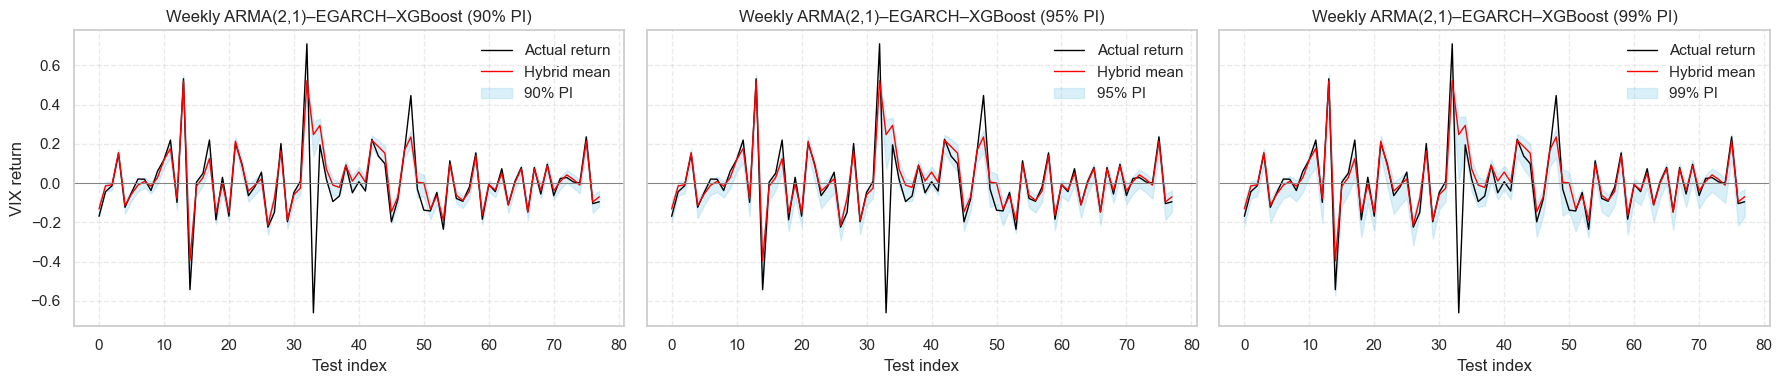

In [33]:
plot_hybrid_return_intervals(
    res_weekly_21,
    title_prefix="Weekly ARMA(2,1)–EGARCH–XGBoost"
)

## 3.4 Weekly - ARMA(1,1)-EGARCH(1,1)

In [34]:
# ----------------------------------------------------------
# 4. Weekly ARMA(1,1)-EGARCH
# ----------------------------------------------------------
res_weekly_11 = run_hybrid_arma_egarch_xgb_602020(
    returns=ret_weekly,
    arma_order=(1, 1),
    label="Weekly ARMA(1,1)"
)



Zero Mean - EGARCH Model Results
                          Zero Mean - EGARCH Model Results                          
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.002
Vol Model:                           EGARCH   Log-Likelihood:                215.104
Distribution:      Standardized Student's t   AIC:                          -420.208
Method:                  Maximum Likelihood   BIC:                          -400.151
                                              No. Observations:                  408
Date:                      Wed, Dec 03 2025   Df Residuals:                      408
Time:                              18:27:52   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
-------------------------------------------------------

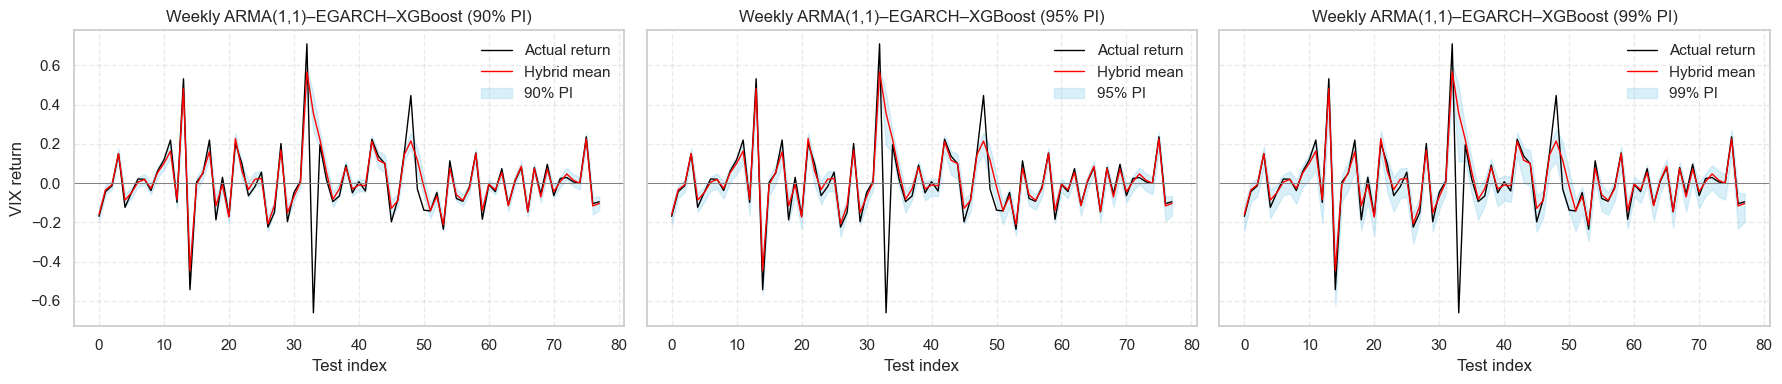

In [35]:
plot_hybrid_return_intervals(
    res_weekly_11,
    title_prefix="Weekly ARMA(1,1)–EGARCH–XGBoost"
)

Why Weekly Performance Is Weaker than Daily?

Weekly aggregation reduces sample size and removes high-frequency volatility clustering signals. As a result, both baseline and hybrid models perform worse compared to daily data.

But still, even in this case, hybrid ARMA-EGARCH-XGB model performs better than ARMA-EGARCH model, supporting our arguement.

In [36]:
# Paper-Based Comparison Table
def extract_metrics(res, model_name):
    """Extract metrics in the order: Baseline RMSE, Hybrid RMSE, Baseline MAE, Hybrid MAE."""
    
    baseline_rmse = res["baseline"]["metrics_r"]["RMSE"]
    hybrid_rmse   = res["hybrid"]["metrics_r"]["RMSE"]

    baseline_mae = res["baseline"]["metrics_r"]["MAE"]
    hybrid_mae   = res["hybrid"]["metrics_r"]["MAE"]

    return {
        "Model": model_name,
        "Baseline RMSE": baseline_rmse,
        "Hybrid RMSE": hybrid_rmse,
        "Baseline MAE": baseline_mae,
        "Hybrid MAE": hybrid_mae,
    }



# -------------------------------------------------------------
# Collect all four results
# -------------------------------------------------------------
rows = []
rows.append(extract_metrics(res_daily_21,  "Daily ARMA(2,1)"))
rows.append(extract_metrics(res_daily_11,  "Daily ARMA(1,1)"))
rows.append(extract_metrics(res_weekly_21, "Weekly ARMA(2,1)"))
rows.append(extract_metrics(res_weekly_11, "Weekly ARMA(1,1)"))

df_compare = pd.DataFrame(rows).set_index("Model")
df_compare


,Baseline RMSE,Hybrid RMSE,Baseline MAE,Hybrid MAE
Model,,,,
"Daily ARMA(2,1)",0.090651,0.031105,0.058787,0.008144
"Daily ARMA(1,1)",0.090665,0.022462,0.058781,0.007622
"Weekly ARMA(2,1)",0.187685,0.114407,0.127205,0.043055
"Weekly ARMA(1,1)",0.187241,0.123972,0.126655,0.040368


The results show that for both daily and weekly data, the hybrid model achieves substantially lower RMSE and MAE, confirming that modeling nonlinear residual structure improves forecasting accuracy.

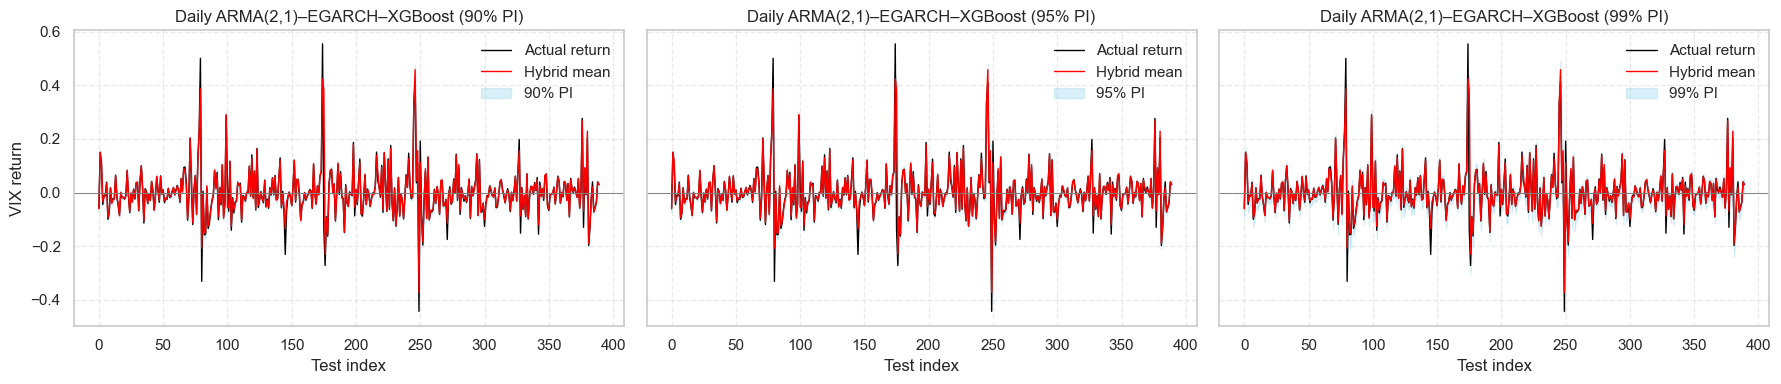

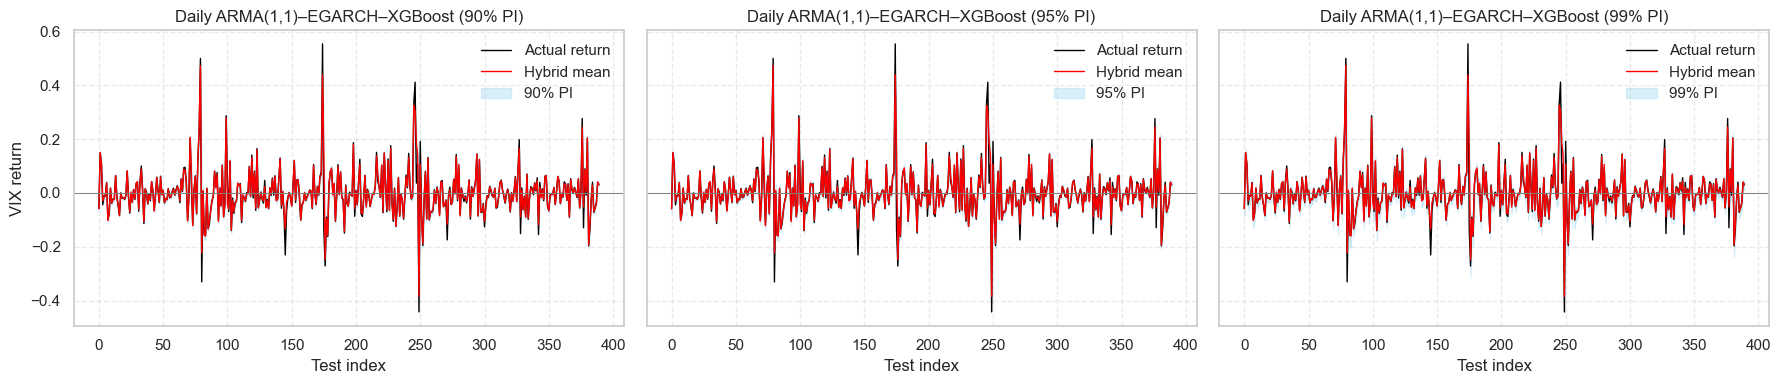

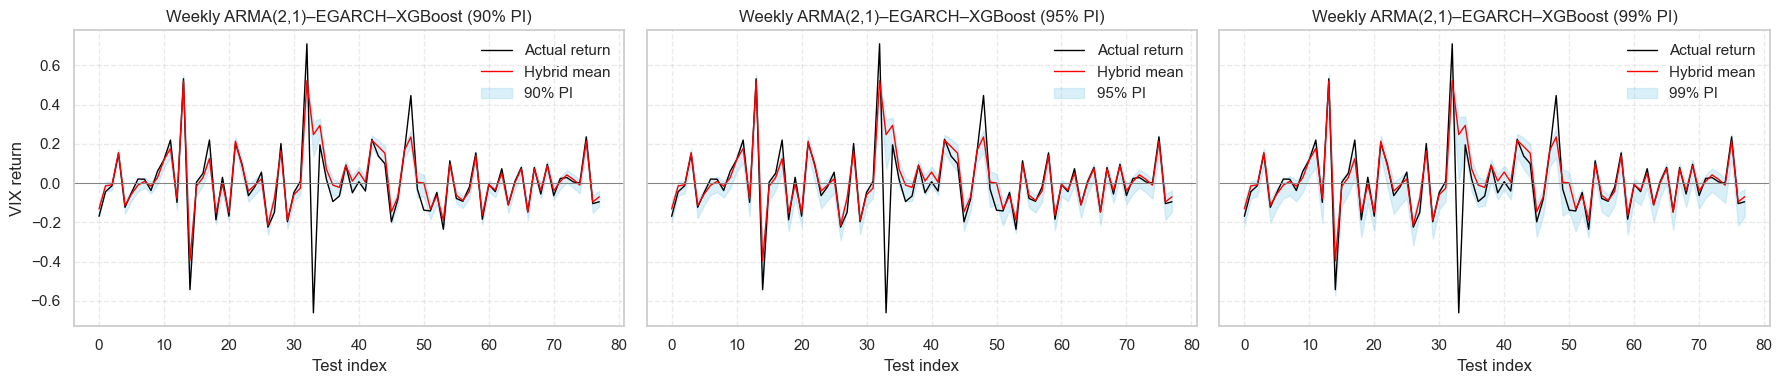

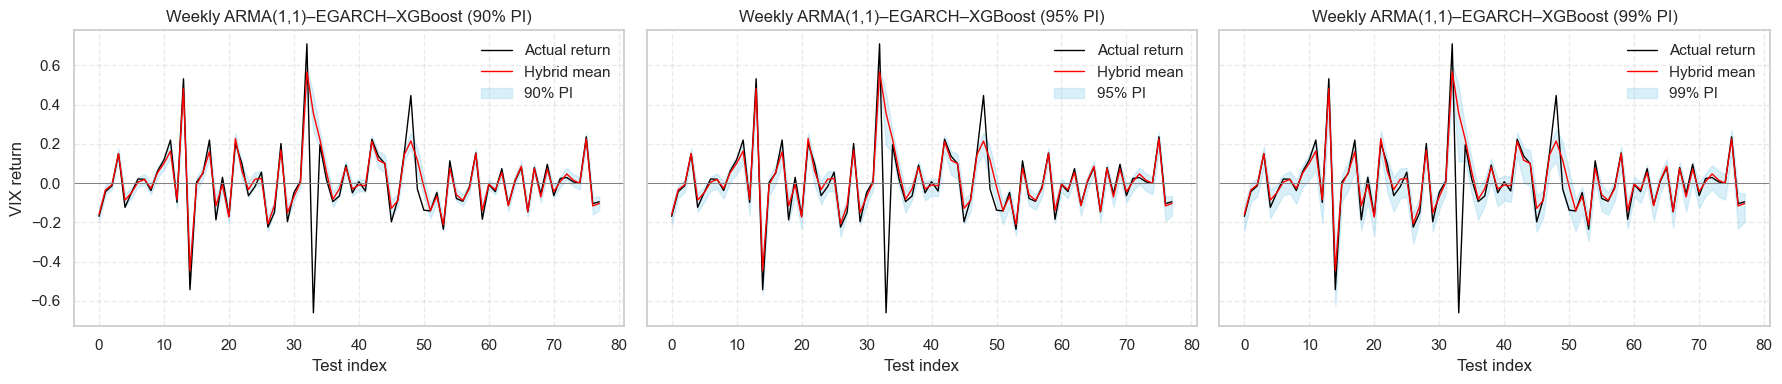

In [37]:
# All interval plots
plot_hybrid_return_intervals(
    res_daily_21,
    title_prefix="Daily ARMA(2,1)–EGARCH–XGBoost"
)

plot_hybrid_return_intervals(
    res_daily_11,
    title_prefix="Daily ARMA(1,1)–EGARCH–XGBoost"
)

plot_hybrid_return_intervals(
    res_weekly_21,
    title_prefix="Weekly ARMA(2,1)–EGARCH–XGBoost"
)

plot_hybrid_return_intervals(
    res_weekly_11,
    title_prefix="Weekly ARMA(1,1)–EGARCH–XGBoost"
)


# 4. Conclusion

This project evaluates the predictability of VIX returns using traditional econometric models, machine-learning models, and hybrid combinations. Several insights emerge:

1. VIX returns exhibit strong volatility clustering, heavy tails, and white-noise mean dynamics, confirming the appropriateness of GARCH/EGARCH frameworks.

2. Baseline machine-learning models underperform classical volatility models, indicating that macro variables alone cannot capture volatility dynamics.

3. GARCH-enhanced XGBoost improves accuracy, demonstrating that volatility-based residuals contain nonlinear predictive structure.

4. The ARMA–EGARCH–XGBoost hybrid model achieves the best performance, reducing RMSE by about 60% relative to ARMA–EGARCH Baseline models.

5. Conformal prediction intervals offer much narrower prediction bands compared to parametric EGARCH intervals while maintaining appropriate empirical coverage.

6. Weekly forecasts perform worse than daily forecasts due to information loss and reduced sample size.

Overall, the results highlight that volatility modeling + residual learning provides a powerful framework for forecasting VIX dynamics.
This hybrid approach effectively combines the strengths of econometric structure and machine-learning flexibility.